In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from IPython.display import Image

## Load data

In [21]:
# Parameters
with open('sharpness/results/PARAM', 'r') as f:
    lines = f.readlines()
    dt = float(lines[7].split(' = ')[1])
    tmax = int(float(lines[5].split(' = ')[1]) / dt)
    a = 1 / (float(lines[6].split(' = ')[1]) / dt)
    
(tmax, a)

(4, 0.25)

In [22]:
fname = 'sharpness/results/0'
i = 2
counter = 0
n_cells = {}
connections = {}

with open(fname + '.txt', 'r') as f:
    lines = f.readlines()

    while i < len(lines):
        if lines[i][0] == '#':
            counter += 1

            s, t, m, n = tuple(map(int, lines[i][2:].split(' ')))

            if not s in n_cells:
                n_cells.update({s: n})
            if not t in n_cells:
                n_cells.update({t: m})

            txt = [l.split() for l in lines[i+1 : i+1+m]]

            c = np.array(txt, dtype=np.float64).reshape((m, n))
            if c.any(): # any non-zeros
                connections.update({(s, t): c})
            i += m + 1
        else:
            raise ValueError

In [23]:
#Image(filename=fname+'.png')

In [24]:
states = dict([(i, np.zeros((tmax, n))) for i, n in n_cells.items()])
states.keys()

dict_keys([0, 1, 2, 3, 4])

In [25]:
ref_prey = np.zeros(n_cells[0], dtype=np.float64)
ref_prey[n_cells[0]//2 :] = 1
ref_pred = np.zeros(n_cells[0], dtype=np.float64)
ref_pred[n_cells[0]//2 :] = 1

def perturb(ref):
#     d = np.abs(np.random.normal(ref, 1, size=n_cells[0]))
#     d_min = d.min()
#     d_max = d.max()
#     d = (d - d_min) / (d_max - d_min)
    return ref

I_prey = perturb(ref_prey)
I_pred = perturb(ref_pred)

In [26]:
# Check connections before doing simulation
connections.keys()

dict_keys([(0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (3, 0), (3, 1), (3, 2)])

In [27]:
def sim(I):
    for t in range(1, tmax):
        states[0][t] = states[0][t-1] + a * (-states[0][t-1] + connections[(1, 0)] @ expit(states[1][t-1]) \
                                             + connections[(2, 0)] @ expit(states[2][t-1]) + I)
        states[1][t] = states[1][t-1] + a * (-states[1][t-1] + connections[(0, 1)] @ expit(states[0][t-1]) \
                                             + connections[(2, 1)] @ expit(states[2][t-1]))
        states[2][t] = states[2][t-1] + a * (-states[2][t-1] + connections[(0, 2)] @ expit(states[0][t-1]) \
                                             + connections[(1, 2)] @ expit(states[1][t-1]))
    
    fig, ax = plt.subplots(1, len(states), sharex='col') # For easy modification in the future
    fig.set_size_inches(5 * len(states), 5)
    fig.tight_layout()
    
    t = np.arange(tmax) * dt
    for i, (k, s) in enumerate(states.items()):
        ax[i].plot(t, s)
        ax[i].set_title('Type %d' % k)
    ax[2].set_xlabel('t')
    ax[1].set_ylabel('activities')
    return states[0][-1], expit(states[2][-1])

In [28]:
def io_compare(I, O):
    fig, ax = plt.subplots(1, 2, sharey='all')
    fig.set_size_inches(10, 5)
    fig.tight_layout()
    ax[0].plot(I, label='original')
    ax[0].plot(O[0], label='modified')
    ax[0].legend()
    ax[0].set_title('receptors')
    ax[1].plot(O[1])
    ax[1].set_title('ganglion')
    ax[0].set_ylabel('activities')
    fig.text(0.5, 0, 'cell index', ha='center')

## Prey

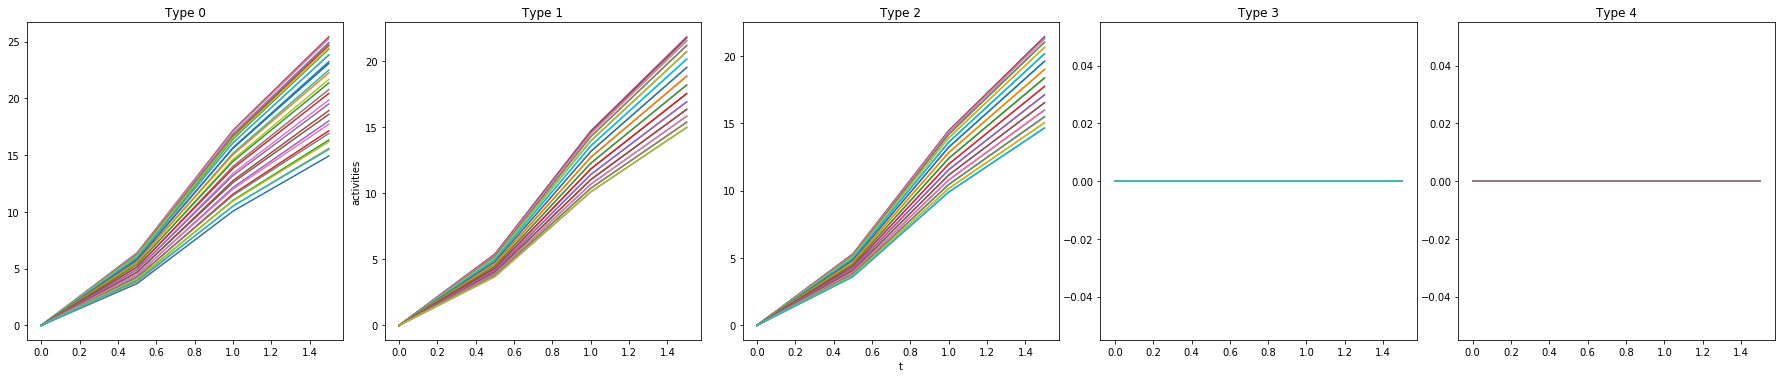

In [29]:
output = sim(I_prey)

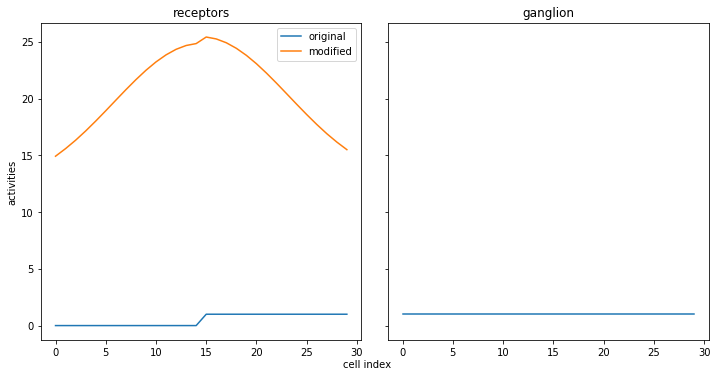

In [30]:
io_compare(I_prey, output)

## Predator

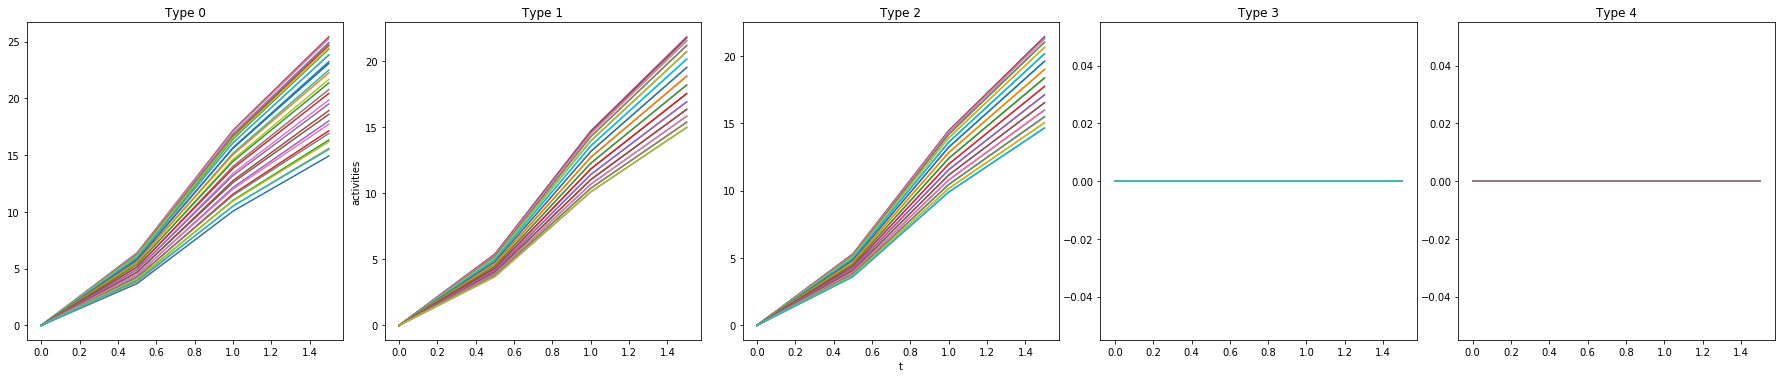

In [31]:
output = sim(I_pred)

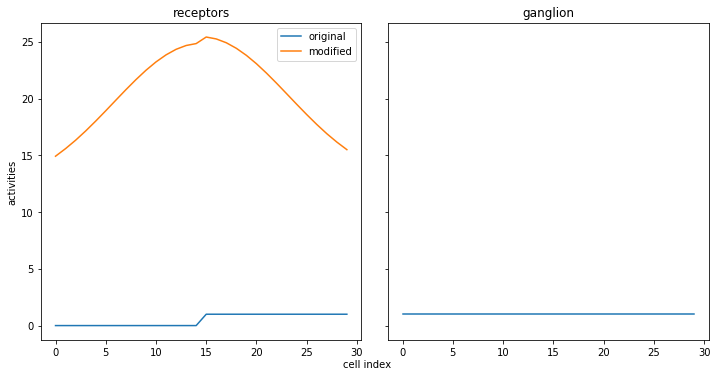

In [32]:
io_compare(I_pred, output)